# Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps

Paper: https://arxiv.org/abs/1312.6034

In [1]:
import json
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from PIL import Image
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [2]:
def img_process(pil_img):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[ 0.485, 0.456, 0.406 ],
                             std=[ 0.229, 0.224, 0.225 ]),
    ])
    return transform(pil_img).unsqueeze(0)

def mask_out(x):
    x[x < 0.0] = 0.0
    x[x > 1.0] = 1.0
    return x

def img_inv_process(tensor):
    if tensor.ndim == 4:
        tensor = tensor.squeeze(0)
    inv_transform = transforms.Compose([
        transforms.Normalize(
            mean=[ -0.485/0.229, -0.456/0.224, -0.406/0.225 ],
            std=[ 1/0.229, 1/0.224, 1/0.225 ]
        ), 
        transforms.Lambda(mask_out),
        transforms.ToPILImage()
    ])
    return inv_transform(tensor)


def save_image(img, path):
    img.save(path)

def open_img(img_path, resize, **kwargs):
    img = Image.open(img_path)
    if resize:
        assert kwargs.get("size") is not None, "if use `resize`, must insert a tuple size to resize"
        img.thumbnail(kwargs["size"])
    return img
    
def init_img(img_path, zero=False, resize=False, **kwargs):
    img = open_img(img_path, resize, **kwargs)
    img_tensor = img_process(img)
    if zero:
        img_tensor = torch.zeros_like(img_tensor)
        return img_inv_process(img_tensor)
    else:
        return img_tensor

In [3]:
img_path = "./data/Image/flamingo.jpg"
img_tensor = init_img(img_path, resize=True, size=(320, 320))
class_to_labels = json.load(open("./data/Image/imagenet1000_clsidx_to_labels.json", 
                                 "r", encoding="utf-8"))
inv_class_to_labels = {v: k for k, v in class_to_labels.items()}
model = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to C:\Users\simon/.cache\torch\checkpoints\resnet152-b121ed2d.pth


In [4]:
def predict(x, model):
    model.eval()
    o = model(x)
    clsidx = o.argmax().item()
    return clsidx

clsidx = predict(img_tensor, model)
print(f"predicted class: {class_to_labels[str(clsidx)]} ({clsidx})")

predicted class: flamingo (130)


In [5]:
class Visualization(nn.Module):
    def __init__(self, model, sv_dir="./data/generated"):
        super(Visualization, self).__init__()
        self.model = deepcopy(model)
        self.model.eval()
        self.model.cpu()
        
        self.sv_dir = Path(sv_dir)
        self.check_path(self.sv_dir)
    
    def check_path(self, p):
        if not isinstance(p, Path):
            p = Path(p)
        if not p.exists():
            p.mkdir(parents=True)
    
    def class_model_visualization(self, img_path, target, lr=6.0, weight_decay=0.0, resize=False, device="cpu", **kwargs):
        sv_path = self.sv_dir / f"{target}" / f"{weight_decay}"
        self.check_path(sv_path)
        
        self.model.to(device)
        zero_img = init_img(img_path, zero=True, resize=resize, **kwargs)
        img_tensor = img_process(zero_img).to(device).requires_grad_(True)
        optimizer = optim.SGD([img_tensor], lr=lr)
        for i in range(151):
            optimizer.zero_grad()
            output = self.model(img_tensor)
            loss = -output[0, target] + weight_decay * torch.norm(img_tensor, p=2) 
            loss.backward()
            optimizer.step()
            
            if i % 10 == 0:
                print(f"[Step {i}] Loss: {loss.item():.4f}")
                pil_img = img_inv_process(img_tensor.clone().detach().cpu())
                save_image(pil_img, str(sv_path / f"iter-{i}.jpg"))
                
        self.model.cpu()
        return pil_img
    
    def generate_saliency_maps(self, img_path, target, resize=False, **kwargs):
        img_tensor = init_img(img_path, resize=resize, **kwargs).requires_grad_(True)
        output = self.model(img_tensor)
        one_hot = torch.zeros_like(output).scatter_(1, torch.LongTensor([target]).unsqueeze(1), 1.0)
        output.backward(one_hot)
        grad = img_tensor.grad.detach().clone()
        grad = torch.abs(grad).max(1)[0].squeeze(0)
        return grad

In [6]:
def experiment(model, img_path, target, lr, weight_decay, resize, device="cuda", **kwargs):
    img = open_img(img_path, resize, **kwargs)
    clsimg = model.class_model_visualization(img_path, target, lr, weight_decay, resize, device, **kwargs)
    saliency = model.generate_saliency_maps(img_path, target, resize, **kwargs)
    return img, clsimg, saliency
    
def show(cls, img, clsimg, saliency):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    
    axes[0].imshow(img)
    axes[1].imshow(clsimg)
    axes[2].imshow(saliency)
    axes[0].set_title(f"Class: {cls}", fontsize=12)
    axes[1].set_title("Class model visualization", fontsize=12)
    axes[2].set_title("Saliency Map", fontsize=12)
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [7]:
classes = ["flamingo", "banana", "tabby-cat"]
targets = [130, 954, 281]
img_path = "./data/Image/{}.jpg"
lr = 6.0
weight_decay = 1e-5
resize = False
size = (320, 320)
device = "cuda"
vis_model = Visualization(model)

In [8]:
cls_dict = {}
for cls, target in zip(classes, targets):
    print(cls)
    img_p = img_path.format(cls)
    cls_dict[cls] = experiment(vis_model, img_p, target, lr, weight_decay, resize, device, size=size)

flamingo
[Step 0] Loss: 2.6967
[Step 10] Loss: -9.9533
[Step 20] Loss: -26.1206
[Step 30] Loss: -41.5553
[Step 40] Loss: -60.8607
[Step 50] Loss: -75.6687
[Step 60] Loss: -91.0142
[Step 70] Loss: -104.2432
[Step 80] Loss: -115.6525
[Step 90] Loss: -127.7699
[Step 100] Loss: -132.5125
[Step 110] Loss: -146.5721
[Step 120] Loss: -155.4201
[Step 130] Loss: -161.4256
[Step 140] Loss: -170.0758
[Step 150] Loss: -178.7807
banana
[Step 0] Loss: -2.1693
[Step 10] Loss: -8.1055
[Step 20] Loss: -17.0585
[Step 30] Loss: -25.7543
[Step 40] Loss: -37.1366
[Step 50] Loss: -46.1461
[Step 60] Loss: -57.1334
[Step 70] Loss: -67.7987
[Step 80] Loss: -74.8064
[Step 90] Loss: -85.1345
[Step 100] Loss: -95.7452
[Step 110] Loss: -103.6865
[Step 120] Loss: -111.9809
[Step 130] Loss: -120.7392
[Step 140] Loss: -128.0401
[Step 150] Loss: -136.4720
tabby-cat
[Step 0] Loss: 0.2264
[Step 10] Loss: -6.1779
[Step 20] Loss: -17.2117
[Step 30] Loss: -24.5532
[Step 40] Loss: -35.2665
[Step 50] Loss: -42.0263
[Step 60]

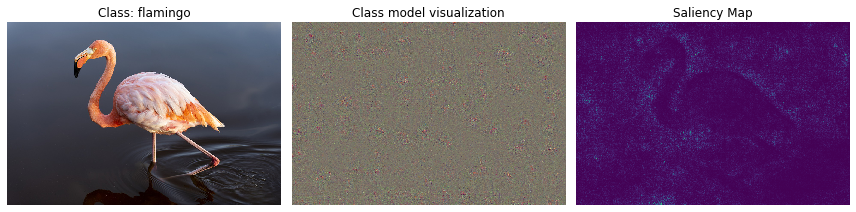

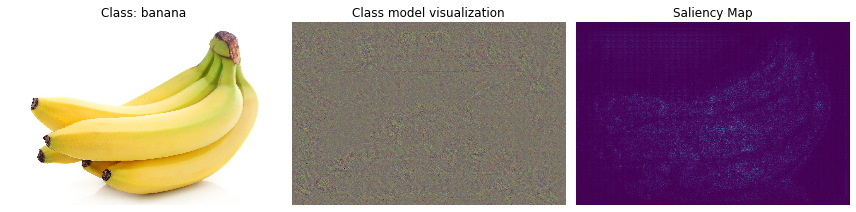

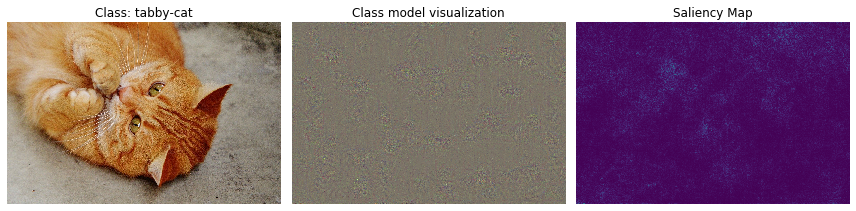

In [11]:
for cls, datas in cls_dict.items():
    show(cls, *datas)